In [8]:
using Plots; pythonplot()
using Distributed

In [9]:
l = 1
N = 1000
c = 1

function linspace(end_point, N::Int)
    list = Float64[]
    increment = Float64(end_point / N)
    for i in range(1, N)
        append!(list, (increment*i)::Float64)
    end
    return list, increment
end

Ψ_one = (x) -> sin(2 * π * x)
Ψ_two = (x) -> sin( 5 * π * x)
function Ψ_three(x)
    if ( x  < 1/5 || x > 2/5)
        return 0
    else
        return sin( 5 * π * x)
    end
end



function initial_vals(x_array::Array, Ψ)
    initial_vals = []
    for x in x_array
        push!(initial_vals, Ψ(x))
    end
    return initial_vals
end

initial_vals (generic function with 1 method)

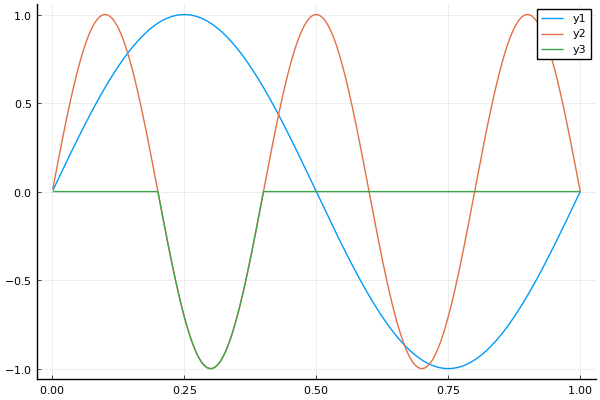

In [10]:
space_array, increment = linspace(1, 1000)

start_values_one = initial_vals(space_array, Ψ_one)
start_values_two = initial_vals(space_array, Ψ_two)
start_values_three = initial_vals(space_array, Ψ_three)
plot(space_array, start_values_one)
plot!(space_array, start_values_two)
plot!(space_array, start_values_three)


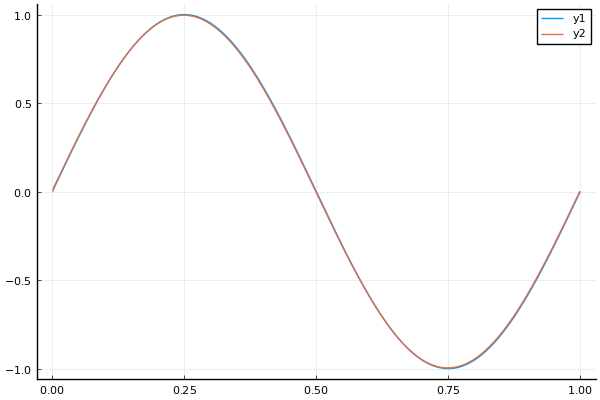

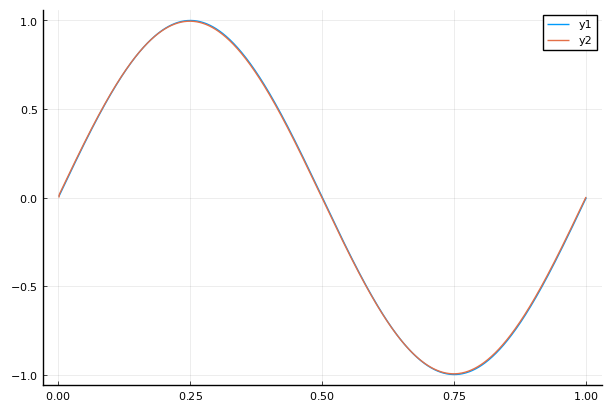

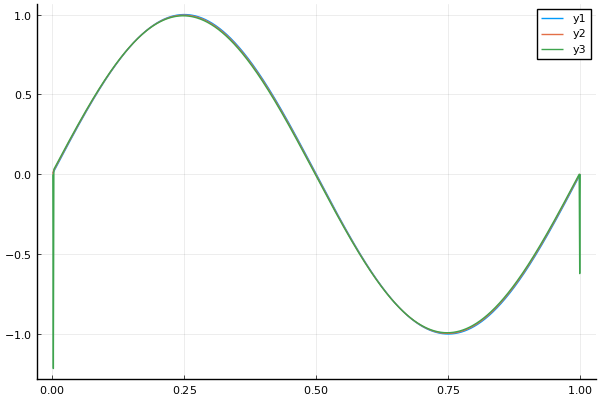

In [11]:
function next_wave_iteration(array, previous_array, c=1, increment_space = increment, increment_time = 0.01)
    new_array = zeros(1000)

    for i in range(1 , length(array) -2)
        i += 1 

        left = array[i-1]
        right = array[i+1]
        current = array[i]
        past = previous_array[i]
        
        new_array[i] = c^2 * ((increment_time)^2 /(increment_space)^2) * (right + left - 2*current) - left + 2*current
    end

    return new_array
end
starting_array = zeros(1000)
new_array = next_wave_iteration(start_values_one, starting_array)
plot(space_array, start_values_one)
display(plot!(space_array, new_array))
new_array = next_wave_iteration(new_array, start_values_one)
plot!(space_array, new_array)
#print(length(start_values_one))

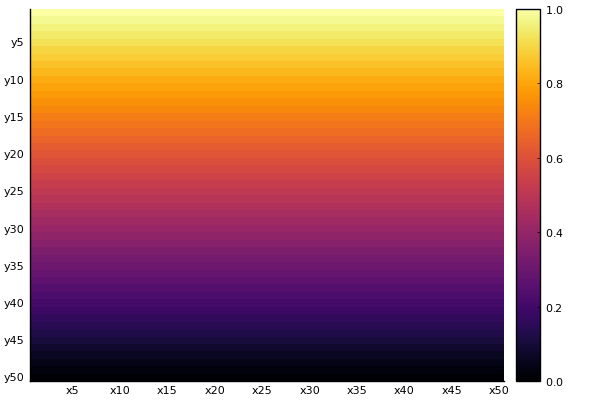

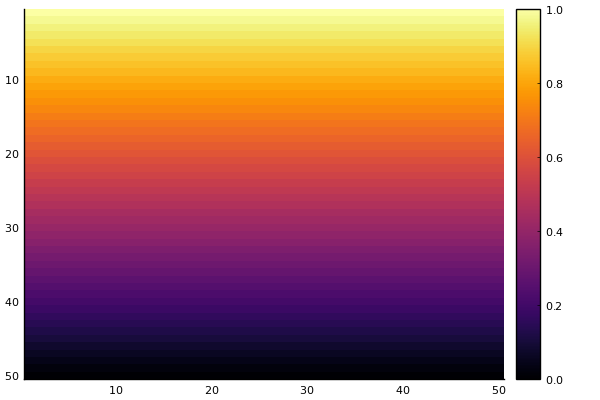

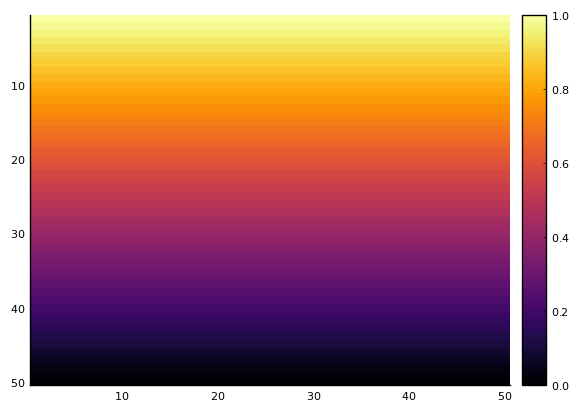

In [13]:
function create_initial_grid(size)
    start_grid = zeros(size, size)
    start_grid[1,:] .= 1
    return start_grid
end

function create_grid_with_boundaries(grid, sinks = [], create_boundaries::Bool = true)
    """ this was later modified to also allow sinks"""
    # [((20,20), (30,30)) , ]
    size = grid[:,1]
    
    for sink in sinks
        upper_left_i = sink[1][1] 
        upper_left_j = sink[1][2]

        lower_right_i = sink[2][1]
        lower_right_j = sink[2][2]

        grid[upper_left_i:lower_right_i, upper_left_j:lower_right_j] .=0
    end

    #x-axis periodic boundaries
    if create_boundaries
        A = grid[:,end-1] 
        C = grid[:,1]
        new_grid = hcat(A, grid ,C) #copy right and left side to opposite side
    else
        new_grid = grid
    end
    
    return new_grid
end


function jacobi_iteration(grid)
    size = length(grid[:,2]) #essential to take vertical bc copied x-axis boundaries
    #println(size)
    new_grid = zeros(size, size)
    new_grid[1,:] .=1
    for i in range(2, size-1) 
        for j in range(2, size+1)
            left  = grid[i, j-1]
            right = grid[i, j+1]
            lower = grid[i+1, j]
            upper = grid[i-1, j]
            
            new_value = (1/4) * (upper + lower + left + right)
            new_grid[i,j-1] = new_value
        end
    end
    return new_grid
end

A = create_initial_grid(50)
for _ in range(1,50000)
    A_boundaries = create_grid_with_boundaries(A)
    A = jacobi_iteration(A_boundaries)
end
A

xs = [string("x", i) for i = 1:50]
ys = [string("y", i) for i = 1:50]

heatmap1 = heatmap(xs, ys, A, yflip = true)
display(heatmap1)

A = create_initial_grid(50)
for _ in range(1,50000)
    A_boundaries = create_grid_with_boundaries(A)
    A = jacobi_iteration(A_boundaries)
end
A

heatmap2 = heatmap(A, yflip=true)
display(heatmap2)




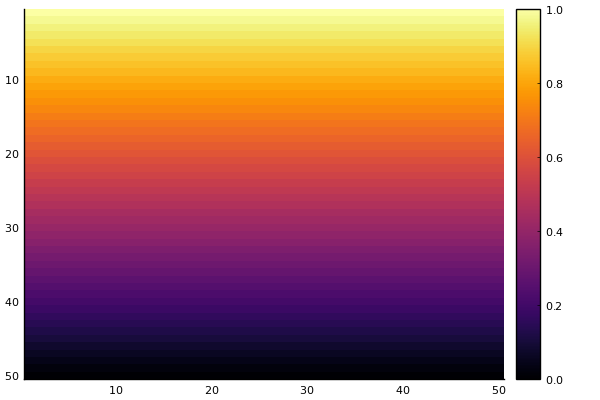

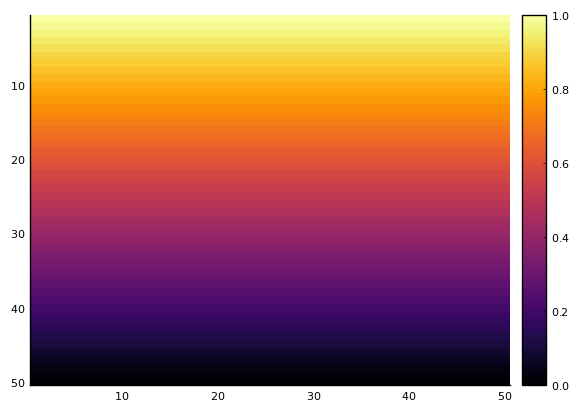

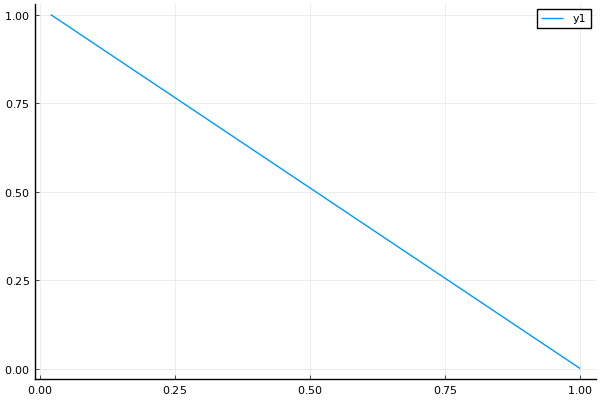

In [ ]:
function gauss_seidel_iteration(grid)
    size = length(grid[:,2]) #essential to take vertical bc copied x-axis boundaries
    #println(size)
    for i in range(2, size-1) 
        for j in range(2, size+1)
            left  = grid[i, j-1]
            right = grid[i, j+1]
            lower = grid[i+1, j]
            upper = grid[i-1, j]
            
            new_value = (1/4) * (upper + lower + left + right)
            grid[i,j] = new_value
        end
    end
    dropped_edges_grid = grid[:,2:end-1]
    return dropped_edges_grid
end

A = create_initial_grid(50)

for _ in range(1,5000)
    A_boundaries = create_grid_with_boundaries(A)
    A = gauss_seidel_iteration(A_boundaries)
end
display(heatmap(A, yflip = true))
x_line = linspace(1,50)
plot(x_line, A[:,1])



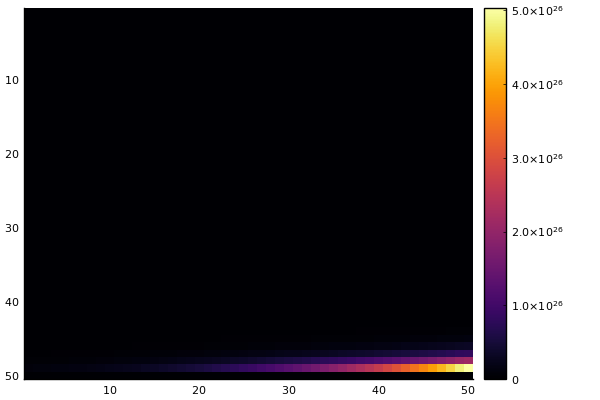

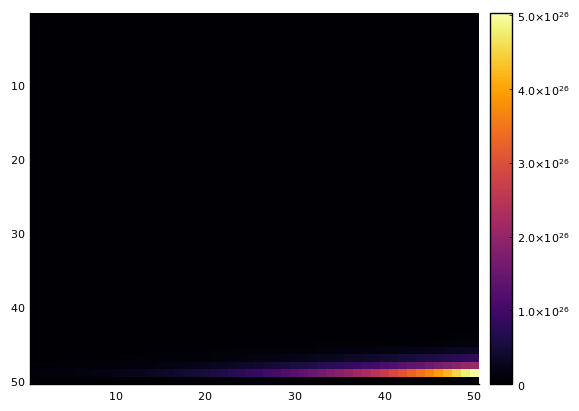

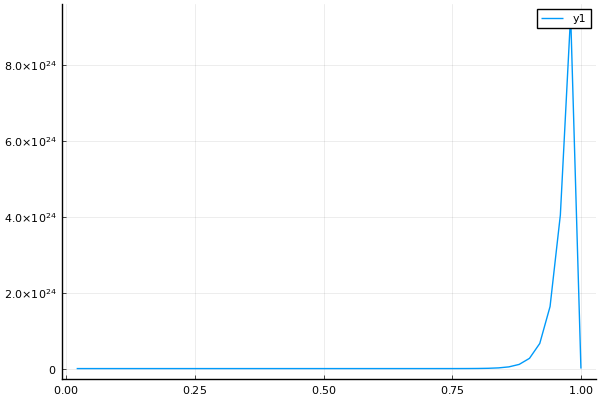

In [15]:
function successive_over_relaxation(grid, ω)
    size = length(grid[:,2]) #essential to take vertical bc copied x-axis boundaries
    #println(size)
    for i in range(2, size-1) 
        for j in range(2, size+1)
            left  = grid[i, j-1]
            right = grid[i, j+1]
            lower = grid[i+1, j]
            upper = grid[i-1, j]
            
            current_value = grid[i,j]
            new_value = (ω/4) * (upper + lower + left + right) + (1 - ω) * current_value
            grid[i,j] = new_value
        end
    end
    dropped_edges_grid = grid[:,2:end-1]
    return dropped_edges_grid
end

A = create_initial_grid(50)
for _ in range(1,5)
    A_boundaries = create_grid_with_boundaries(A)
    A = successive_over_relaxation(A_boundaries, 3)
end

display(heatmap(A, yflip = true))
x_line = linspace(1,50)
plot(x_line, A[:,1])


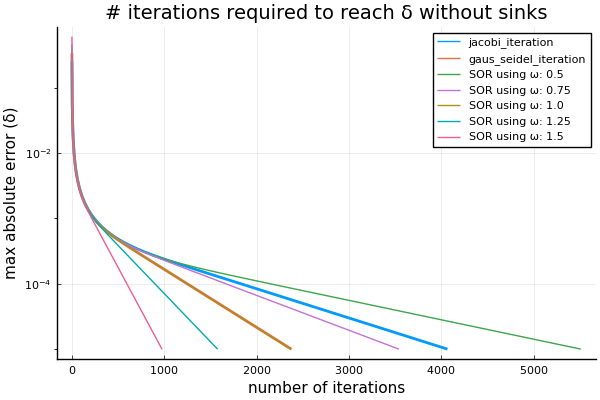

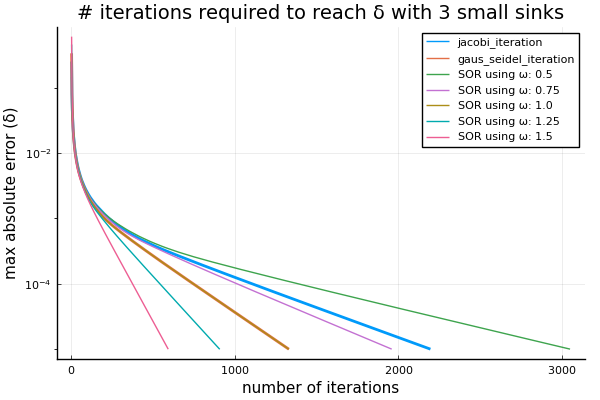

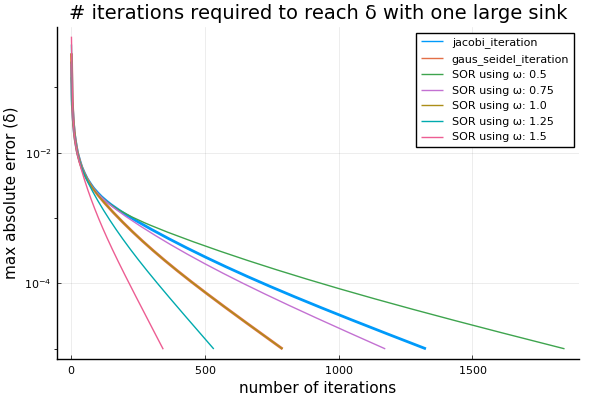

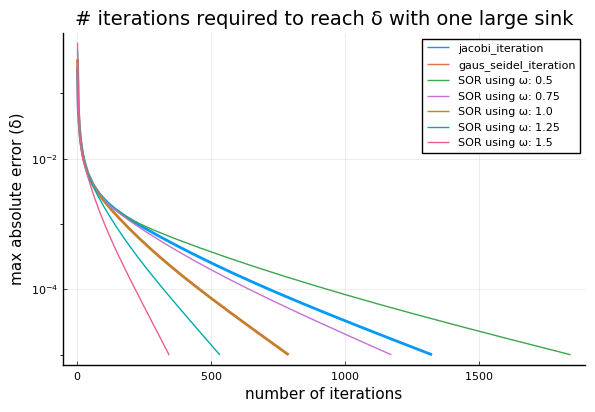

"c:\\Users\\sijme\\Documents\\GitHub\\scicomp\\big_sinks.png"

In [ ]:
function convergence_measure(grid_old, grid_new)
    size = length(grid_old[:,1])

    # error cases
    if size != length(grid_old[1,:])
        println("old grid is not square")
        return
    end

    if length(grid_new[:,1]) != length(grid_new[1,:])
        println("new grid is not square")
        return
    end

    if size != length(grid_new[:,1])
        println("grids are not same shape")
        return
    end

    current_max = -Inf64
    for i in 1:size
        for j in 1:size
            difference = abs(grid_new[i,j] - grid_old[i,j])
            if difference > current_max
                current_max = difference
            end
        end
    end
    return current_max
end

function create_convergence_graph(size::Int, sinks::Array = [], title="# iterations required to reach δ")
    """
    size: choose size of the grid you want to analyse, has to be an integer
    sinks: temperature sinks expects list of tuples with tuples with ints ex.[ ((UL),(LR)) , ((UL),(LR)) ] 
           of upper left (UL) and lower right (LR) coordinates of location where you want your sink(s) example
           would create two sinks
    """
    δ = 10^-5
    method_list = [jacobi_iteration, gauss_seidel_iteration]
    ω_values = [0.5 ,0.75, 1, 1.25, 1.5]
    image = plot(title= title, yscale=:log10)
    xlabel!("number of iterations")
    ylabel!("max absolute error (δ)")
    

    for method in method_list
        current_error = Inf
        current_grid = create_initial_grid(50) 
        i=0
        graph_values = []
        while current_error > δ
            comparison_grid = current_grid
            boundary_grid = create_grid_with_boundaries(current_grid, sinks)
            current_grid = method(boundary_grid)
            current_grid = create_grid_with_boundaries(current_grid, sinks, false) # set sinks to zero
            current_error = convergence_measure(comparison_grid, current_grid)
            push!(graph_values, current_error)
            i +=1

        end
        x_vals = [x for x in 1:i]
        plot!(x_vals, graph_values, label= method, linewidth=2)
    end

    for ω in ω_values
        current_error = Inf
        current_grid = create_initial_grid(50) 
        i=0
        graph_values = []
        while current_error > δ
            comparison_grid = current_grid
            boundary_grid = create_grid_with_boundaries(current_grid, sinks) #create boundaries
            current_grid = successive_over_relaxation(boundary_grid, ω)
            current_grid = create_grid_with_boundaries(current_grid, sinks, false) # set sinks to zero
            current_error = convergence_measure(comparison_grid, current_grid)

            push!(graph_values, current_error)
            i +=1
        end
        x_vals = [x for x in 1:i]
        plot!(x_vals, graph_values, label= "SOR using ω: $ω", linewidth=1 )
    end
    display(image)
end
no_sinks = create_convergence_graph(50, [], "# iterations required to reach δ without sinks" )
savefig("no_sinks")

small_sinks = create_convergence_graph(50, [((2,2),(4,4)),((35,35),(36, 39)),((20, 20),(24, 21))],
                                        "# iterations required to reach δ with 3 small sinks") # three small sinks in middle
savefig("three_sinks")

big_sink = create_convergence_graph(50, [((15,15),(35,35))], 
                                    "# iterations required to reach δ with one large sink") # one biggass sink
savefig("big_sinks")



In [10]:
function find_optimal_ω(size, start, stop, step, δ= 10^-5, sinks = [])
    ω_list = [ω for ω in range(start, stop, step= step)]
    iteration_list = []

    #known correct to measure against
    correct_grid =  create_initial_grid(size)
    for _ in range(1,500000)
        A_boundaries = create_grid_with_boundaries(correct_grid, sinks)
        correct_grid = jacobi_iteration(A_boundaries)
        correct_grid = create_grid_with_boundaries(correct_grid, sinks, false)
    end


    for ω in ω_list
        current_error = Inf
        current_grid = create_initial_grid(size) 
        i=0
        
        while current_error > δ
            boundary_grid = create_grid_with_boundaries(current_grid, sinks) #create boundaries
            current_grid = successive_over_relaxation(boundary_grid, ω)
            current_grid = create_grid_with_boundaries(current_grid, sinks, false) # set sinks to zero
            
            # assignment asked to compair gridstep t-1 with t, however this approach is more stabe in case that
            # the entire matrix explodes +Inf where each step the difference would be 0 but totaly incorrect solution
            # so to compair fairly i used this method. in the create_convergence_graph() the requested method is used
            current_error = convergence_measure(correct_grid, current_grid) 
            i +=1

            if i > 10^5
                break
            end

        end
        push!(iteration_list, [ω, i])
    end
    return stack(iteration_list)
end

iteration_counts =find_optimal_ω(50, 1.9, 1.98, 0.01)

println(minimum(iteration_counts[2,:]))

plot(iteration_counts[1,:], iteration_counts[2,:])
ylims!(0,10000)

iteration_counts


301.0


2×9 Matrix{Float64}:
   1.9    1.91    1.92     1.93       1.94  …      1.96      1.97      1.98
 301.0  321.0   512.0   1362.0   100001.0      29180.0   19742.0   14037.0

size: 10 done
size: 20 done
size: 30 done
size: 40 done
size: 50 done
size: 60 done
size: 70 done
size: 80 done
size: 90 done
size: 100 done


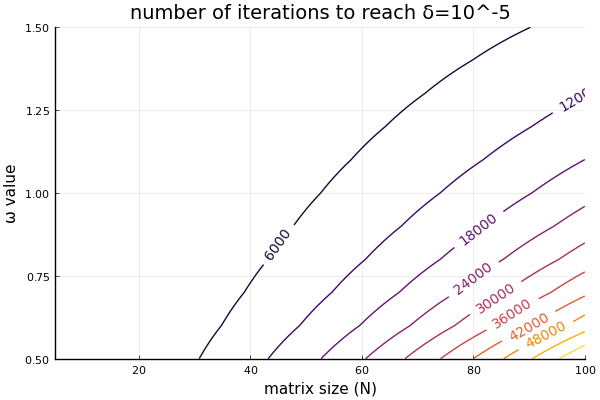

In [ ]:

z_vals = []
sizes = [s for s in 5:100]
start = 0.5
stop =1.5
increment = 0.1
ω_list = [ω for ω in range(start, stop, step= increment)]

for size in sizes
    iteration_counts =find_optimal_ω(size, start, stop, increment)
    push!(z_vals, iteration_counts[2,:])
    if size % 10 ==0
        println("size: $size done")

    end
end

z_vals = stack(stack(z_vals))
image = contour(sizes, ω_list, z_vals, levels=[150, 600, 2000, 4500, 9000, 15000, 22000,30000, 42000 ,52000],
                clabels=true, cbar=false , lw=1)
xlabel!("matrix size (N)")
ylabel!("ω value")
title!("number of iterations to reach δ=10^-5")

#display(image)

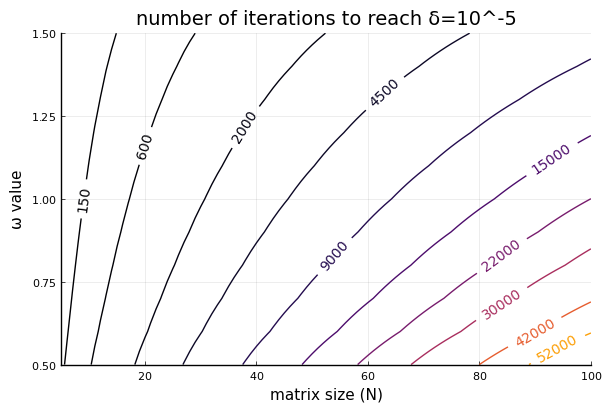

"c:\\Users\\sijme\\Documents\\GitHub\\scicomp\\num_iterations_plot.png"

In [31]:
image = contour(sizes, ω_list, z_vals, levels=[150, 600, 2000, 4500, 9000, 15000, 22000,30000, 42000 ,52000] ,clabels=true, cbar=false , lw=1)
xlabel!("matrix size (N)")
ylabel!("ω value")
title!("number of iterations to reach δ=10^-5")
savefig("num_iterations_plot")

[ Info: Saved animation to c:\Users\sijme\Documents\GitHub\scicomp\obama.gif


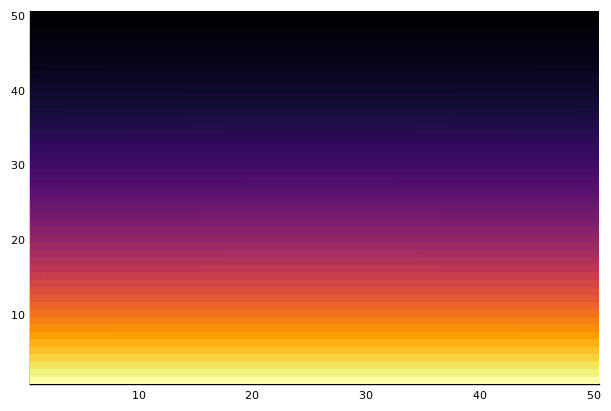

Plots.AnimatedGif("c:\\Users\\sijme\\Documents\\GitHub\\scicomp\\obama.gif")
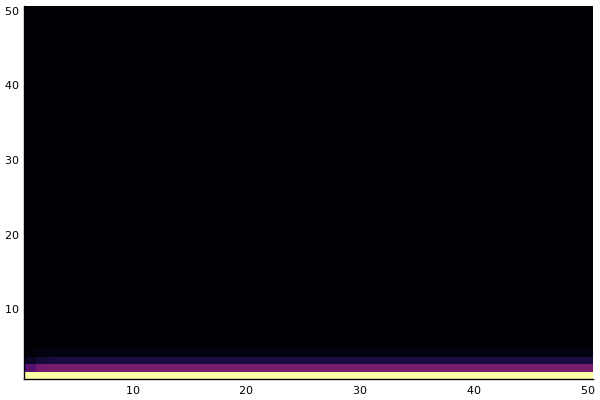

In [ ]:
A = create_initial_grid(50)

vmin, vmax = extrema(A)

p = heatmap(A, clim=(vmin, vmax), colorbar=false)

anim = @animate for i in 1:500
    global A
    A_boundaries = create_grid_with_boundaries(A)
    A = gauss_seidel_iteration(A_boundaries)

    heatmap!(p, A, clim=(vmin, vmax))
end

gif(anim, "obama.gif", fps=50)

In [ ]:
A = create_initial_grid(30)

vmin, vmax = extrema(A)

p = heatmap(A, clim=(vmin, vmax), colorbar=false)
sinks = [((4,4),(8,8))]
anim = @animate for i in 1:300
    global A
    A_boundaries = create_grid_with_boundaries(A, sinks)
    A = gauss_seidel_iteration(A_boundaries)
    A = create_grid_with_boundaries(A, sinks, false) 
    heatmap!(p, A, clim=(vmin, vmax))
end

gif(anim, "obama.gif", fps=100)

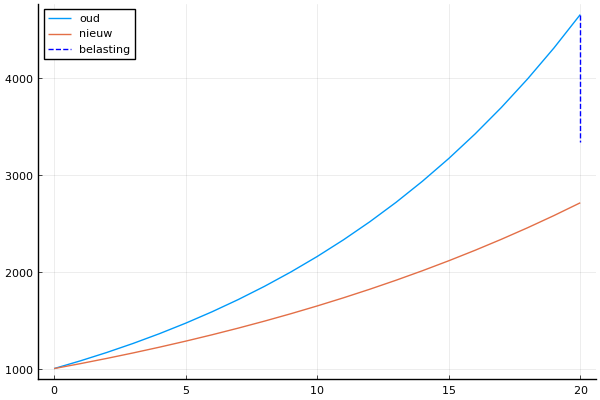

totaal aantal belasting oud: 1317.9445717857511
totaal aantal belasting nieuw: 964.4667176021528
[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0; 1000.0 1080.0 1166.4 1259.7120000000002 1360.4889600000004 1469.3280768000004 1586.8743229440006 1713.8242687795207 1850.9302102818824 1999.0046271044332 2158.924997272788 2331.638997054611 2518.17011681898 2719.6237261644987 2937.193624257659 3172.169114198272 3425.942643334134 3700.0180548008652 3996.019499184935 4315.7010591197295 4660.9571438493085; 1000.0 1051.2 1105.02144 1161.598537728 1221.0723828596738 1283.5912888620892 1349.3111628518282 1418.395894389842 1491.017764182602 1567.3578737087512 1647.6065968426394 1731.9640546009828 1820.640614196553 1913.8574136434167 2011.8469132219595 2114.853475178924 2223.133973108085 2336.958432531219 2456.610704276817 2582.38917233579 2714.6074979593827]

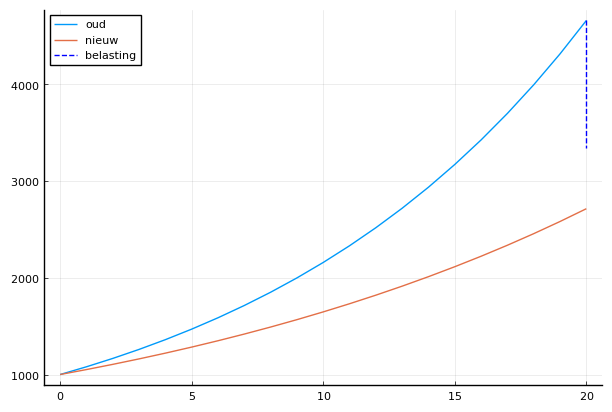

In [75]:
function oud(x)
    return x*1.08
end

function nieuw(x)
    x_new = x*1.08
    belasting = (x_new - x)*0.36
    over = x_new-belasting
    return over, belasting
end

vals=[]
belasting_lst=[]
start_oud = 1000
start_nieuw = 1000
push!(vals, [0, start_oud, start_nieuw])
for jaar in 1:20
    start_oud = oud(start_oud)
    start_nieuw, belasting = nieuw(start_nieuw)
    push!(vals, [jaar, start_oud, start_nieuw])
    push!(belasting_lst, belasting)
end

vals = hcat(vals...)
plot(vals[1,:],vals[2,:], label = "oud", legend = :topleft)
plot!(vals[1,:],vals[3,:], label="nieuw")
eindbelasting_oud = (vals[2,end] - 1000) * 0.36
eindwaarde_oud = vals[2,end] - eindbelasting_oud
eindbelasting_nieuw = sum(belasting_lst)
plot!([vals[1,end],vals[1,end]], [vals[2,end], eindwaarde_oud], linestyle = :dash, c= "blue", label="belasting")
display(current())
println("totaal aantal belasting oud: $eindbelasting_oud")
println("totaal aantal belasting nieuw: $eindbelasting_nieuw")
print(vals)

